In [66]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

In [11]:
# Load your dataset (assuming it's saved locally)
df_balanced = pd.read_csv("C:\\Users\\prabh\\Documents\\Customer_review_analysis_LSTM\\Customer_review_analysis_LSTM\\Dataset\\amazon_alexa.tsv", sep='\t')


In [12]:
df_balanced.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [13]:
df_balanced.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [14]:
#Column names

print(f"Feature names : {df_balanced.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [15]:
#Check for null values

df_balanced.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [16]:
#Getting the record where 'verified_reviews' is null 

df_balanced[df_balanced['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [17]:
#We will drop the null record

df_balanced.dropna(inplace=True)

In [18]:
print(f"Dataset shape after dropping null values : {df_balanced.shape}")

Dataset shape after dropping null values : (3149, 5)


In [20]:
#Randomly checking for 78th record

print(f"'verified_reviews' column value: {df_balanced.iloc[78]['verified_reviews']}") #Original value
print(f"Length of review : {len(df_balanced.iloc[78]['verified_reviews'])}") #Length of review using len()

'verified_reviews' column value: I LIKE IT ALL
Length of review : 13


In [21]:
df_balanced.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

In [22]:
print(f"Rating value count: \n{df_balanced['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


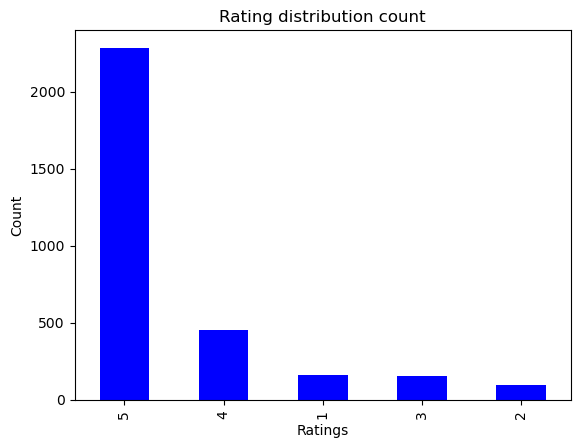

In [31]:
#Bar plot to visualize the total counts of each rating

df_balanced['rating'].value_counts().plot.bar(color = 'blue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

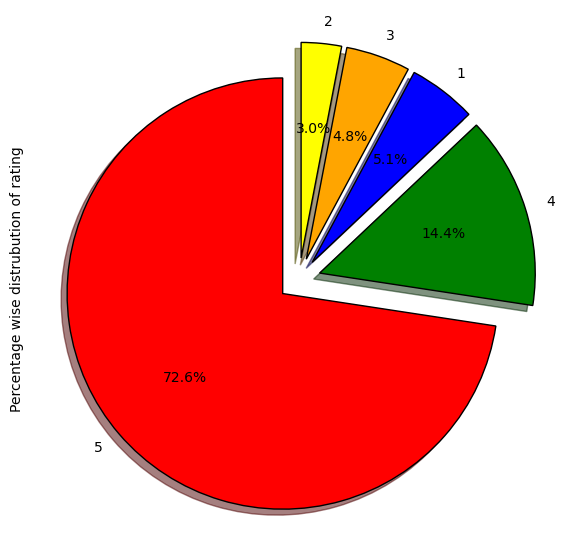

In [33]:
#Creating a Pie chart with Percentage distribution of Ratings
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df_balanced['rating'].value_counts()/df_balanced.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

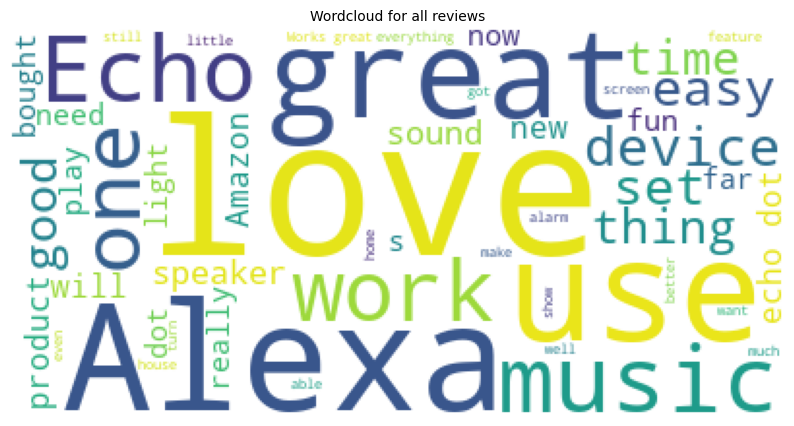

In [37]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df_balanced.verified_reviews)
# Combine all reviews
reviews = " ".join([review for review in df_balanced['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()


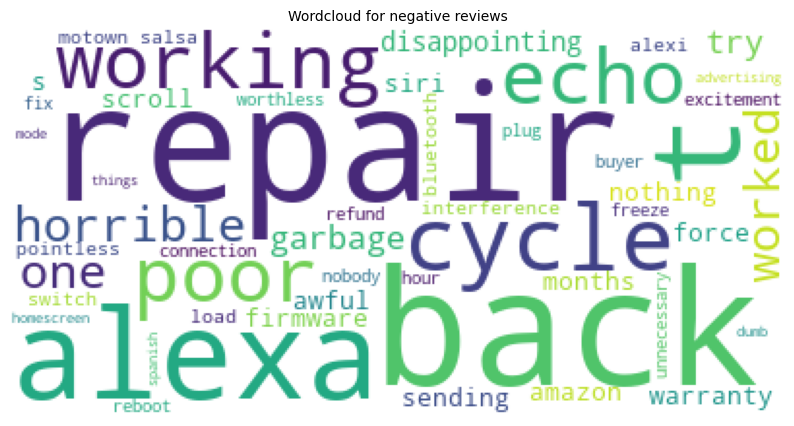

In [38]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in df_balanced[df_balanced['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df_balanced[df_balanced['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

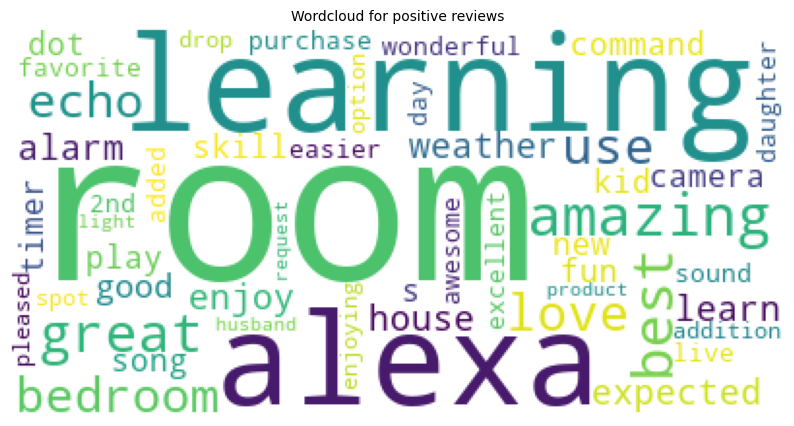

In [39]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [41]:
# Preprocessing the text
def preprocess_text(text):
    # Remove unwanted characters and clean the text
    return text.str.lower().replace(r'[^a-zA-Z\s]', '', regex=True)

In [42]:
# Preprocess the reviews column
df_balanced['verified_reviews'] = preprocess_text(df_balanced['verified_reviews'])

In [43]:
# Convert all reviews to strings and fill missing values with an empty string
df_balanced['verified_reviews'] = df_balanced['verified_reviews'].astype(str).fillna('')

# Preprocessing the text
def preprocess_text(text):
    # Remove unwanted characters and clean the text
    return text.str.lower().replace(r'[^a-zA-Z\s]', '', regex=True)

# Preprocess the reviews column
df_balanced['verified_reviews'] = preprocess_text(df_balanced['verified_reviews'])

# Tokenizing the text (limiting the vocabulary size to 5000)
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(df_balanced['verified_reviews'].values)

# Convert the text to sequences
X = tokenizer.texts_to_sequences(df_balanced['verified_reviews'].values)
X = pad_sequences(X)

# Label encode the target variable (ratings)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanced['rating'])
y = to_categorical(y)  # Convert labels to one-hot encoding


In [44]:
# Convert the text to sequences
X = tokenizer.texts_to_sequences(df_balanced['verified_reviews'].values)
X = pad_sequences(X)

In [45]:
# Label encode the target variable (ratings)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanced['rating'])
y = to_categorical(y)  # Convert labels to one-hot encoding

In [46]:
# Split the data into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
40/40 - 53s - 1s/step - accuracy: 0.8773 - loss: 0.3618 - val_accuracy: 0.7206 - val_loss: 0.8959
Epoch 2/10
40/40 - 52s - 1s/step - accuracy: 0.8940 - loss: 0.3100 - val_accuracy: 0.7381 - val_loss: 0.8858
Epoch 3/10
40/40 - 46s - 1s/step - accuracy: 0.9047 - loss: 0.2715 - val_accuracy: 0.7444 - val_loss: 0.9410
Epoch 4/10
40/40 - 80s - 2s/step - accuracy: 0.9154 - loss: 0.2347 - val_accuracy: 0.7365 - val_loss: 0.9338
Epoch 5/10
40/40 - 48s - 1s/step - accuracy: 0.9313 - loss: 0.2088 - val_accuracy: 0.7460 - val_loss: 0.9813
Epoch 6/10
40/40 - 61s - 2s/step - accuracy: 0.9405 - loss: 0.1816 - val_accuracy: 0.7460 - val_loss: 1.0105
Epoch 7/10
40/40 - 47s - 1s/step - accuracy: 0.9472 - loss: 0.1647 - val_accuracy: 0.7540 - val_loss: 1.0787
Epoch 8/10
40/40 - 47s - 1s/step - accuracy: 0.9520 - loss: 0.1510 - val_accuracy: 0.7365 - val_loss: 1.1225
Epoch 9/10
40/40 - 49s - 1s/step - accuracy: 0.9551 - loss: 0.1406 - val_accuracy: 0.7460 - val_loss: 1.1223
Epoch 10/10
40/40 -

In [70]:
# Evaluate the model on test data
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Adding sentiment analysis using TextBlob
df_balanced['sentiment_score'] = df_balanced['verified_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display the first few rows with sentiment scores
print(df_balanced[['verified_reviews', 'rating', 'sentiment_score']].head())

Test Accuracy: 74.29%
                                    verified_reviews  rating  sentiment_score
0                                       love my echo       5             0.50
1                                           loved it       5             0.70
2  sometimes while playing a game you can answer ...       4            -0.10
3  i have had a lot of fun with this thing my  yr...       5             0.35
4                                              music       5             0.00


In [71]:
# Get predictions from the model on test data
y_pred_prob = model.predict(X_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions (argmax)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


In [72]:
# Convert y_test from one-hot encoding to label encoding if necessary
y_true = np.argmax(y_test, axis=1)  # This assumes y_test is in one-hot encoded form

In [73]:
# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 74.29%


In [74]:
# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')


Precision: 0.7357


In [75]:
# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

Recall: 0.7429


In [76]:
# 4. F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-Score: {f1:.4f}')

F1-Score: 0.7309


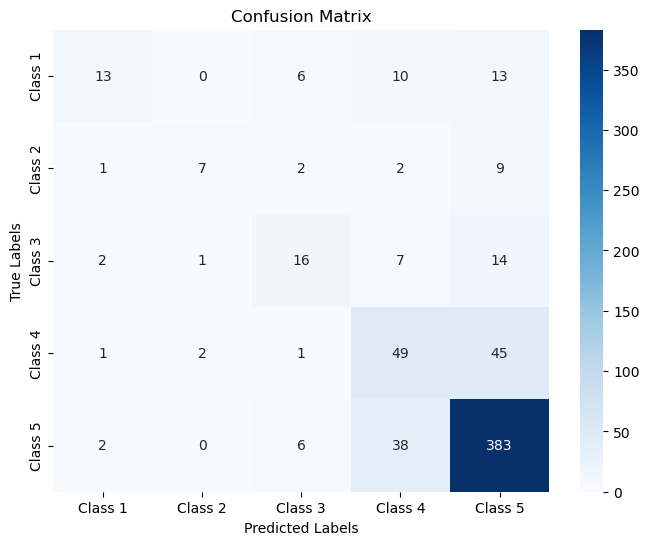

In [77]:
# 5. Confusion Matrix
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels (replace these with your actual class names)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Example for 5 classes

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [78]:
# 6. ROC-AUC Score (for multi-class classification using one-vs-rest approach)
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_true)  # Binarize the true labels
auc = roc_auc_score(y_true_binarized, y_pred_prob, average='weighted', multi_class='ovr')
print(f'ROC-AUC Score: {auc:.4f}')

ROC-AUC Score: 0.8134


In [80]:
model = model.save('E_commerce_model.h5')